# Malaria Cell Detection

This R-CNN model is trained to detect the location of malaria cells in images.

### Dependencies 

In [ ]:
pip install torch numpy matplotlib pandas tensorflow-macos tensorflow-datasets opencv-python pillow

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import display
from PIL import Image
import random

## Loading the Data

Getting the malaria dataset from the tensorflow library and loading it into a DataLoader from torch. 


In [2]:
# Getting the malaria dataset from the tensorflow library and loading it into a DataLoader from torch. 
malaria_ds = tfds.load(
    'malaria', 
    split='train', 
    as_supervised=True, 
    with_info=True)
df = tfds.as_dataframe(malaria_ds[0], malaria_ds[1])
print(df.shape)

2022-06-06 23:43:33.681713: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(27558, 2)


### Preview Samples

Have a look at the samples: 

In [3]:
def show_malaria_image(image, label): 
    plt.imshow(image, cmap='gray')
    plt.title("Uninfected" if label else "Infected", loc='center')
    plt.ylabel(f"Height ({image.shape[0]})")
    plt.xlabel(f"Width ({image.shape[1]})")
    plt.show()

In [4]:
def show_samples(samples):
    x = int(len(samples) / 2)
    y = len(samples) - x
    for i in range(len(samples)):
        plt.subplot(x, y, i + 1)
        plt.subplots_adjust(hspace=1)
        plt.imshow(samples[i][0], cmap='gray')
        plt.title("Uninfected" if samples[i][1] else "Infected", loc='center')
        plt.ylabel(f"Height ({samples[i][0].shape[0]})")
        plt.xlabel(f"Width ({samples[i][0].shape[1]})")
    plt.show()

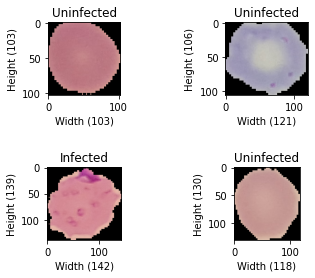

In [5]:
show_samples(df[:4].values)

### Exploring the Data

We now perform a quick exploration of the data.

Number of different shapes:  1627


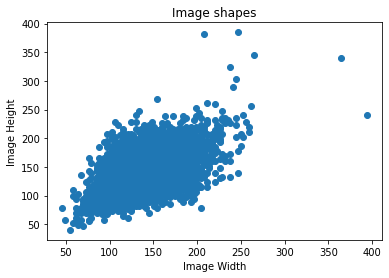

In [10]:
shapes = []
outliers = []
for image, label in zip(df["image"], df["label"]):
    if image.shape not in shapes: 
        shapes.append(image.shape)
    if image.shape[0] > 300 or image.shape[1] > 300:
        outliers.append((image, label))

print("Number of different shapes: ", len(shapes))

# create a scatter plot of the different shapes
plt.title("Image shapes")
plt.scatter(x=[shape[1] for shape in shapes],y=[shape[0] for shape in shapes])
plt.ylabel("Image Height")
plt.xlabel("Image Width")
plt.show()

In [ ]:
print(f"There are {len(outliers)} images with a width or height greater than 300")
outlier_shapes = np.array([img[0].shape for img in outliers])
table = pd.DataFrame(data=outlier_shapes[:,:2], columns=["Height", "Width"])
display(table)

index = int(input("Enter the number of the image to show: "))
assert index < len(outliers)
show_malaria_image(outliers[index][0], outliers[index][1])

## Data Augmentation

We will use the following transforms to augment the data:

* Resize the data for the model
* Random rotation and zoom
* Width and height 
* Shear intensity
* Horizontal flip

### Resizing the Images

We can use the PIL library to resize the images to a fixed size.

In [5]:
# Function to resize the image
def resize(image, size): 
    resized = Image.fromarray(image).resize(size, resample=Image.BOX)
    return np.array(resized)

See how large images will be after resizing:

In [ ]:
# See the image before and after resizing
index = int(input("Enter the number of the image to resize: "))
print(f"Outlier {index} before resize: {outlier_shapes[index]}")
show_malaria_image(outliers[index][0], outliers[index][1])
# See how the large images with unequal proportions are resized
resized_image = resize(outliers[index][0], (150, 150))
print(f"Outlier {index} after resize: {resized_image.shape}")
show_malaria_image(resized_image, outliers[index][1])

See how small images will be after resizing:

In [ ]:
# Get small images with width and height smalles than 70
small_images = [(image, label) for (image, label) in zip(df["image"], df["label"]) if image.shape[0] < 70 and image.shape[1] < 70]
print(f"There are {len(small_images)} images with a width and height smaller than 70")
small_shapes = np.array([img[0].shape for img in small_images])
table = pd.DataFrame(data=small_shapes[:,:2], columns=["Height", "Width"])
display(table)
# See how the small images are after resizing
index = int(input("Enter the number of the image to show: "))
assert index < len(small_images)
show_malaria_image(small_images[index][0], small_images[index][1])
resized_img = resize(small_images[index][0], (150, 150))
print("After resizing to (150, 150):")
show_malaria_image(resized_img, small_images[index][1])

Resizing all the images: 

In [6]:
# resize all the images and store back into df
df["image"] = df["image"].apply(lambda x: resize(x, (64, 64)))

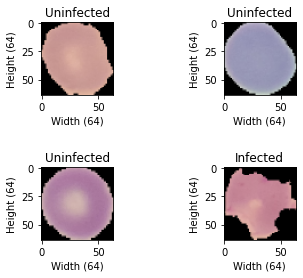

In [7]:
# get list of 4 random number within len(df)
indexes = random.sample(range(len(df)), 4)
show_samples(df.iloc[indexes].values)

### Splitting the Data

We will split the data into training and validation. 

In [35]:
df_trn = df.iloc[:int(len(df) * 0.8)]
df_val = df.iloc[int(len(df) * 0.8):]

### Data Loader

Now that the data is ready, we can use create a DataLoader that will be used for training.

In [9]:
class MalariaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.n_samples = len(dataframe)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image, label = self.dataframe.iloc[index]
        if self.transform: 
            image = self.transform(image)
        return image, label

In [36]:
batch_size = 64
train_dataset = MalariaDataset(df_trn, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = MalariaDataset(df_val, transform=transforms.ToTensor())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Let's check that the data loader is working properly:

In [ ]:
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}")
    print(images.shape)
    show_samples([[np.transpose(image.numpy(),(2, 1, 0)), label] for (image, label) in zip(images, labels)])
    if i == 2: 
        break

# Model Architecture

The model architecture is as follows:
* CNN model with FC layers
* Convolutional 3x3 layers
* Maxpool 2x2
* Fully connected layers
* Activation function: ReLU

### Defining the Model

We use the nn.Module class to define the model.

In [37]:
class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 6, 5), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 10, 5), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(10 * 13 * 13, 512),
            nn.ReLU(),
            nn.Linear(512, 64), 
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    def forward(self, x): 
        output = self.conv_layers(x)
        # print(output.size())
        output = output.view(-1, 10 * 13 * 13)
        output = self.fc_layers(output)
        return output

In [38]:
learning_rate = 0.001

model = CNN()

loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Check that the model architecture is correct:

In [24]:
for i, (images, labels) in enumerate(train_loader):
    # ensure labels are same size and type
    labels = labels.unsqueeze(1).float()
    outputs = model(images)
    loss_value = loss(outputs, labels)
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()
    break

torch.Size([64, 10, 13, 13])


## Training the Model



In [39]:
num_steps = len(train_loader)
print(len(df_trn), num_steps)

22046 345


In [34]:
def evaluate(model, loader): 
    total_err = 0
    total_samples = 0
    for images, labels in loader: 
        # ensure labels are same size and type
        outputs = model(images)
        correct = (outputs > 0.0).squeeze().long() != labels
        total_err += int(correct.sum())
        total_samples += len(labels)
    return float(total_err) / total_samples

Epoch 1/30, Loss: 0.37177377939224243, Validation Error: 0.11810595065312046
Epoch 2/30, Loss: 0.09894032031297684, Validation Error: 0.07910014513788098
Epoch 3/30, Loss: 0.173585444688797, Validation Error: 0.06059506531204644
Epoch 4/30, Loss: 0.16496804356575012, Validation Error: 0.05097968069666183
Epoch 5/30, Loss: 0.10863962024450302, Validation Error: 0.048802612481857764
Epoch 6/30, Loss: 0.19770602881908417, Validation Error: 0.05188679245283019
Epoch 7/30, Loss: 0.07964321970939636, Validation Error: 0.04680696661828737
Epoch 8/30, Loss: 0.013971186242997646, Validation Error: 0.046625544267053703
Epoch 9/30, Loss: 0.005208552349358797, Validation Error: 0.045718432510885344
Epoch 10/30, Loss: 0.22630992531776428, Validation Error: 0.05315674891146589
Epoch 11/30, Loss: 0.28902667760849, Validation Error: 0.04970972423802612
Epoch 12/30, Loss: 0.02851586975157261, Validation Error: 0.048802612481857764
Epoch 13/30, Loss: 0.07715484499931335, Validation Error: 0.053338171262

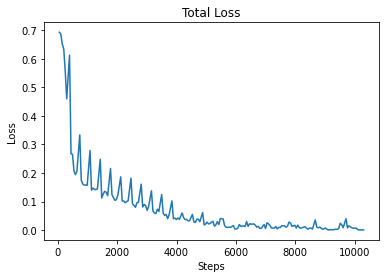

In [40]:
num_epochs = 30
running_loss = 0 
total_loss = []
total_steps = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        # ensure labels are same size and type
        labels = labels.unsqueeze(1).float()
        # forward pass
        outputs = model(images)
        loss_value = loss(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        # for statistics
        running_loss += loss_value.item()
        if (i + 1) % 50 == 0: 
            total_loss.append(running_loss / 50)
            total_steps.append(epoch * num_steps + i)
            running_loss = 0
    validation_error = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_value.item()}, Validation Error: {validation_error}")

# show total loss
plt.title("Total Loss")
plt.plot(total_steps, total_loss)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()


## Evaluating the Model

We can now test the model on the validation set.

In [41]:
accuracy = 1 - evaluate(model, val_loader)
print(f"Validation accuracy: {accuracy:.4f}")


Validation accuracy: 0.9447
